In [1]:
library(rdmc)
library(tidyverse)
library(ape)
theme_set(cowplot::theme_cowplot(15))
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

Loading required package: MASS

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: purrr

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: rlang


Attaching package: ‘rlang’


The following object is masked from ‘package:magrittr’:

    set_names


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice


── Attaching packages ───────────────────────────────

In [2]:
gen_map_all_chr <- read_delim("../data/map/ogut_v5.map.txt", delim = "\t") %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    cm_bp <- tibble(rr = (df2$cm - df1$cm)/(df2$pos - df1$pos)/100)
    bind_cols(df2, cm_mb, cm_bp)
  }) %>% 
  mutate(chr = paste0("chr", chr))


median(gen_map_all_chr$rr)

get_rr <- function(genetic_df, sweep_chr, sweep_positions){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  median(approx(x = chr_df$pos, y = chr_df$rr, xout = sweep_positions)$y)
}

get_cm <- function(genetic_df, sweep_chr, sweep_start, sweep_end){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  cm_start <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_start)$y
  cm_end <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_end)$y
  cm_end - cm_start
}


gmap <- "../data/map/ogut_v5.map.txt"
gen_map_all_chr <- vroom::vroom(gmap, delim = "\t") %>%
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>%
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    cm_bp <- tibble(rr = (df2$cm - df1$cm)/(df2$pos - df1$pos)/100)
    bind_cols(df2, cm_mb, cm_bp)
  }) %>%
  ungroup() %>% 
  mutate(chr = paste0("chr", chr))

median(gen_map_all_chr$rr)



#how to get a constant density of samples over sweeps that vary in their **genetic** size (not physical)
#get_cm(gen_map_all_chr, "chr1", sweep_freqs$end[1], tail(sweep_freqs$end, 1))


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chr = col_double(),
  pos = col_double(),
  cm = col_double()
)




[1] 1.641221e-08

Rows: 6,490
Columns: 3
Delimiter: "\t"
dbl [3]: chr, pos, cm

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] 1.641221e-08

In [3]:


MIN_FREQ <- 1/20
DEFAULT_SITES <- 1e4
MAX_SITES <- 1e5
MIN_SITES <- 1e3
SNP_K  <- 250000

s_file <- "../data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start31723921_end31727430_pops3-4.txt"

start <- str_split(s_file, "start", simplify = TRUE) %>% 
    `[`(2) %>% 
    str_split("_", simplify = TRUE) %>% 
    `[`(1) %>% 
    as.numeric(c)

end <- str_split(s_file, "end", simplify = TRUE) %>% 
    `[`(2) %>% 
    str_split("_", simplify = TRUE) %>% 
    `[`(1) %>% 
    as.numeric(c)

sweep_cM <- get_cm(gen_map_all_chr, "chr1", start, end)
n_snps <- round(SNP_K*sweep_cM)
if(is.na(n_snps)) n_snps <- DEFAULT_SITES

n_sites <- case_when(
    is.na(n_snps) ~ NA_real_,
    n_snps >= MIN_SITES && n_snps <= MAX_SITES ~ n_snps,
    n_snps < MIN_SITES ~ MIN_SITES,
    n_snps > MAX_SITES ~ MAX_SITES,
)

n_snps

[1] 1050

In [8]:
print("here")
vroom::vroom(file = s_file,   
    delim = "\t",
    col_names = FREQ_POPS)  %>% head()


[1] "here"


Rows: 22,969
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



chrom,start,end,v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--random1_Palmar_Chico,v5--LR--San_Lorenzo,v5--Teo--Amatlan_de_Canas,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--random1_Palmar_Chico,v5--Teo--San_Lorenzo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10,100236986,100236987,0.00000,0.000000,0.00000,0e+00,0.000000,1e-06,1e-06,4e-06,0e+00,0,3e-06
chr10,100236987,100236988,0.30554,0.062504,0.11333,4e-06,0.070145,1e-06,0e+00,4e-06,0e+00,0,2e-06
chr10,100236988,100236989,0.00000,0.000000,0.00000,0e+00,0.000000,1e-06,1e-06,4e-06,1e-06,0,5e-06
chr10,100236989,100236990,0.00000,0.000000,0.00000,0e+00,0.000000,1e-06,0e+00,6e-06,0e+00,0,2e-06
chr10,100236990,100236991,0.00000,0.000000,0.00000,0e+00,0.000000,1e-06,1e-06,6e-06,1e-06,0,2e-06
chr10,100236991,100236992,0.00000,0.000000,0.00000,0e+00,0.000000,1e-06,0e+00,6e-06,0e+00,0,2e-06


In [6]:
FREQ_POPS = c(
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
)

MIN_FREQ <- 1/20
neutral_freqs <- vroom::vroom(file = "../data/rdmc/v5--neutral_freqs.txt",   
    delim = "\t",
    col_names = FREQ_POPS) %>%
    mutate(varz = apply(select(., -c(chrom, start, end)), 1, max)) %>% 
    filter(varz >= MIN_FREQ) %>%
    sample_n(50000) %>% 
    select(-varz) 


s_file <- "../data/rdmc/sweep_freq/v5--sweep--chr10--0--152435371_start100234619_end100464359_pops1-4-10.txt"
#s_file <- "../test_chr_start7110396592_end110877024_1MB_buffer_sweep_pops1-2-3-4-5.txt"
#s_file <- "../sweep_test.txt"
#str_split(s_file, "pops", simplify = FALSE)

sel_vec <- str_split(s_file, "pops", simplify = TRUE)[,2] %>% 
        str_remove(".txt") %>% 
        str_split("-", simplify = TRUE) %>% 
        as_vector() %>% 
        as.numeric()

#sel_vec <- c(1,4,8)

sel_vec


sweep_freqs <- vroom::vroom(file = s_file,   
    delim = "\t",
    col_names = FREQ_POPS)  %>% 
    mutate(varz = apply(select(., -c(chrom, start, end)), 1, max)) %>% 
    filter(varz >= MIN_FREQ) %>%
    select(-varz) %>% 
    sample_n(min(nrow(.), n_sites)) %>% 
    arrange(start) 


nrow(neutral_freqs)
nrow(sweep_freqs)

sweep_freqs[0:10, ]
#sweep_freqs %>% 
#    apply(select(., -c(chrom, start, end)), 1, var)
#    apply(., 1, var)


Rows: 1,000,000
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1]  1  4 10

Rows: 22,969
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] 50000

[1] 1050

chrom,start,end,v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--random1_Palmar_Chico,v5--LR--San_Lorenzo,v5--Teo--Amatlan_de_Canas,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--random1_Palmar_Chico,v5--Teo--San_Lorenzo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10,100237050,100237051,0.000000,0.057221,0.000000,0,0e+00,0.000000,0.052209,0.054305,0.096416,0.000000,0.070652
chr10,100237096,100237097,0.000000,0.000000,0.000000,0,0e+00,0.000000,0.000000,0.000000,0.154549,0.000000,0.000000
chr10,100237142,100237143,0.000000,0.154336,0.000000,0,0e+00,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000
chr10,100237145,100237146,0.000000,0.103260,0.051720,0,0e+00,0.000000,0.050376,0.041848,0.102601,0.000000,0.071999
chr10,100237154,100237155,0.000000,0.051361,0.000000,0,0e+00,0.000000,0.000001,0.000000,0.000000,0.000000,0.000001
chr10,100237155,100237156,0.000000,0.000000,0.000000,0,0e+00,0.377161,0.000000,0.000000,0.051390,0.312654,0.000001
chr10,100237170,100237171,0.000000,0.000000,0.000000,0,0e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.401178
chr10,100237223,100237224,0.000000,0.059588,0.000000,0,0e+00,0.000001,0.000001,0.000000,0.000001,0.000001,0.000001
chr10,100237253,100237254,0.054629,0.000000,0.113021,0,1e-06,0.195755,0.000003,0.000003,0.000003,0.000000,0.000003


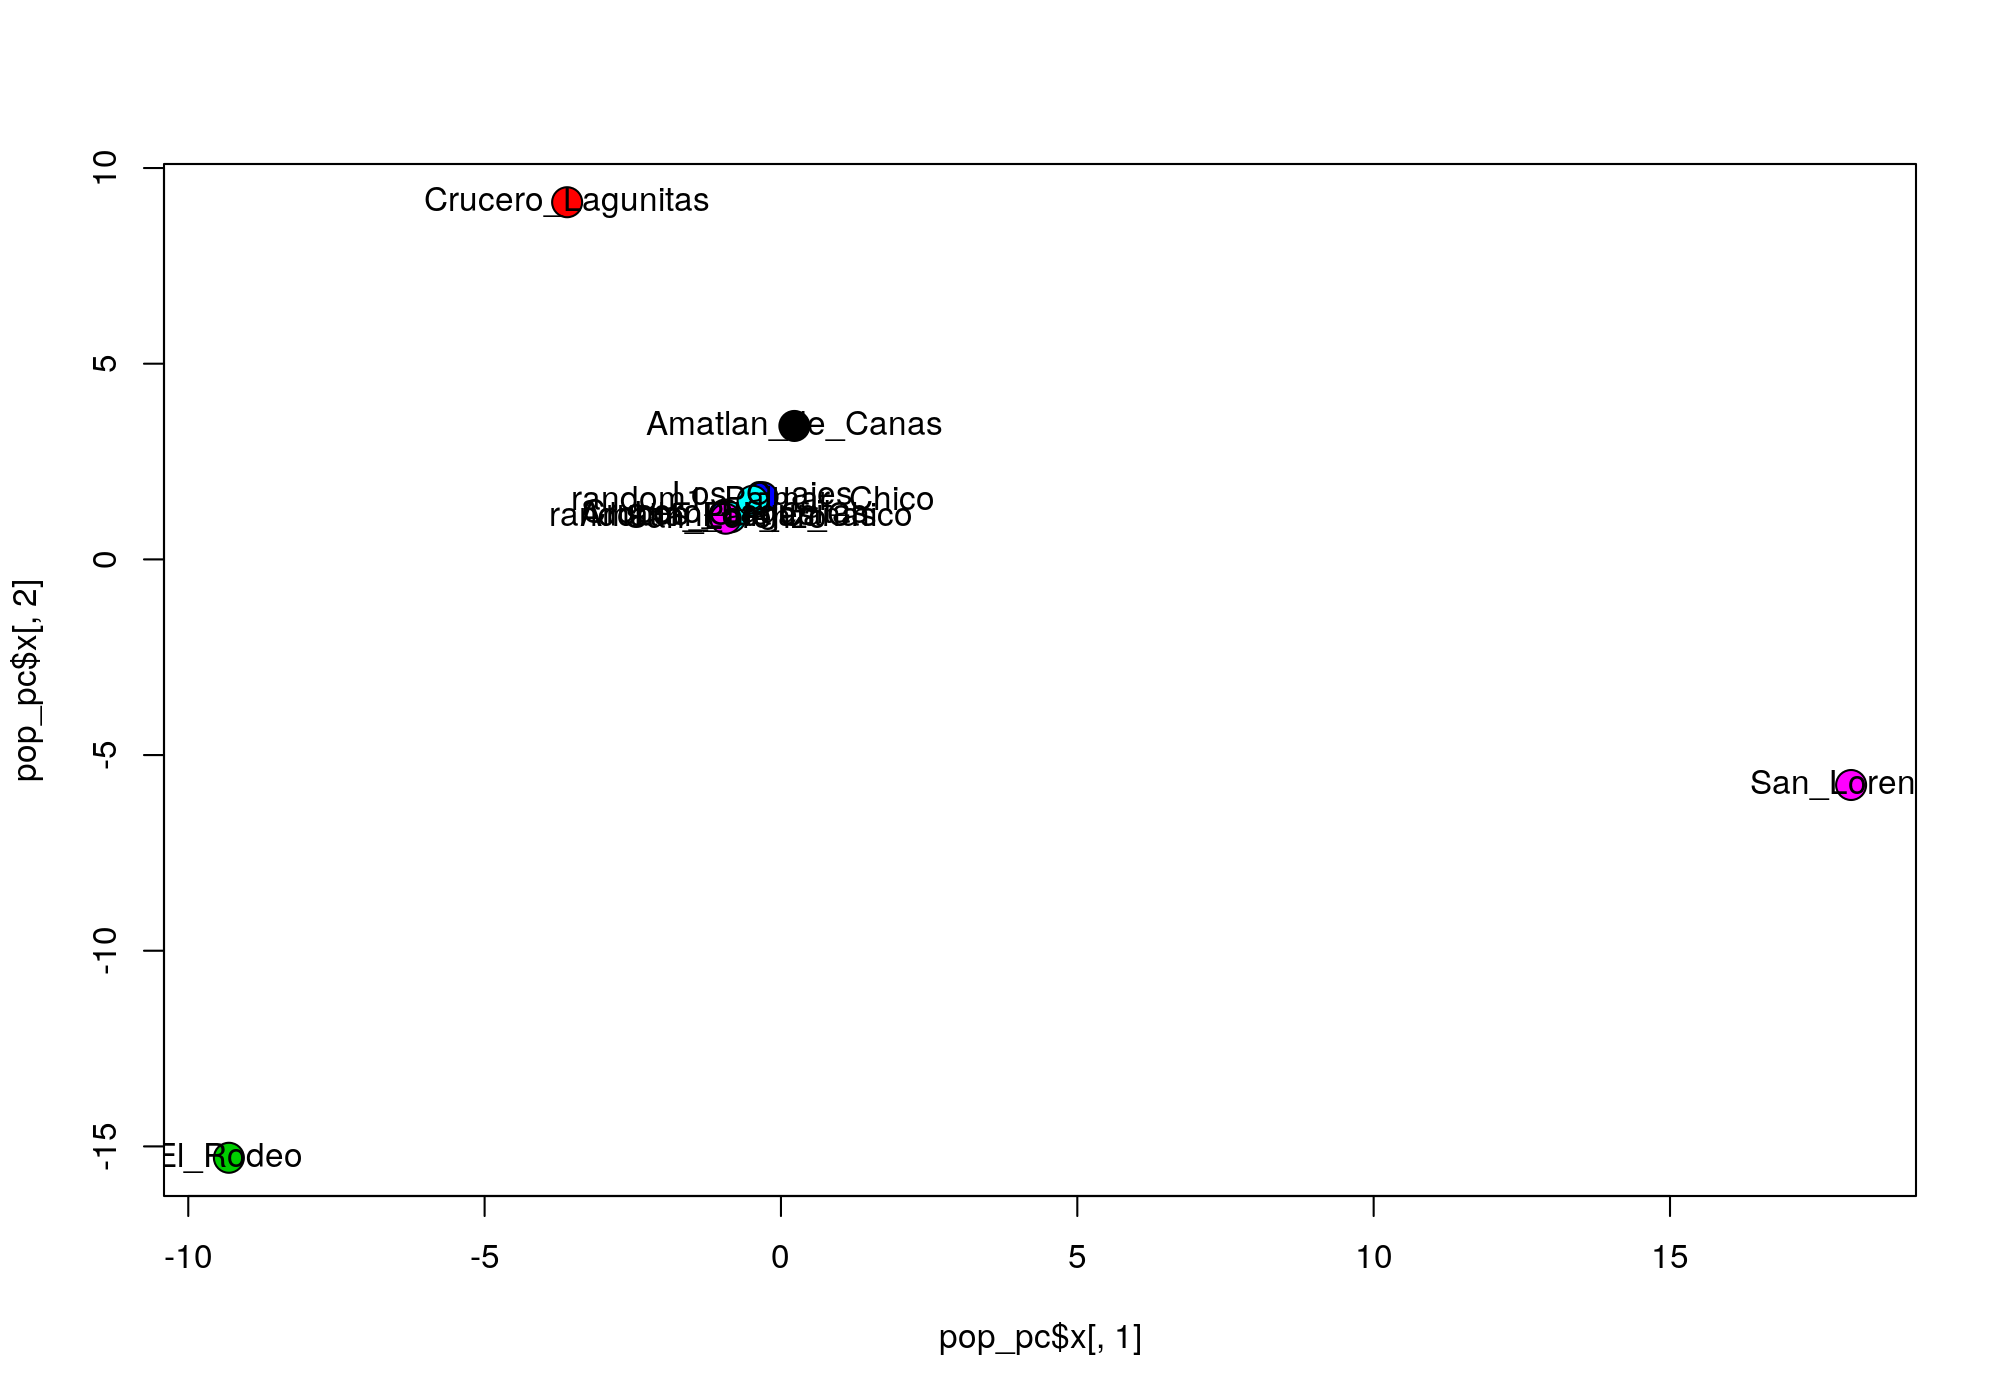

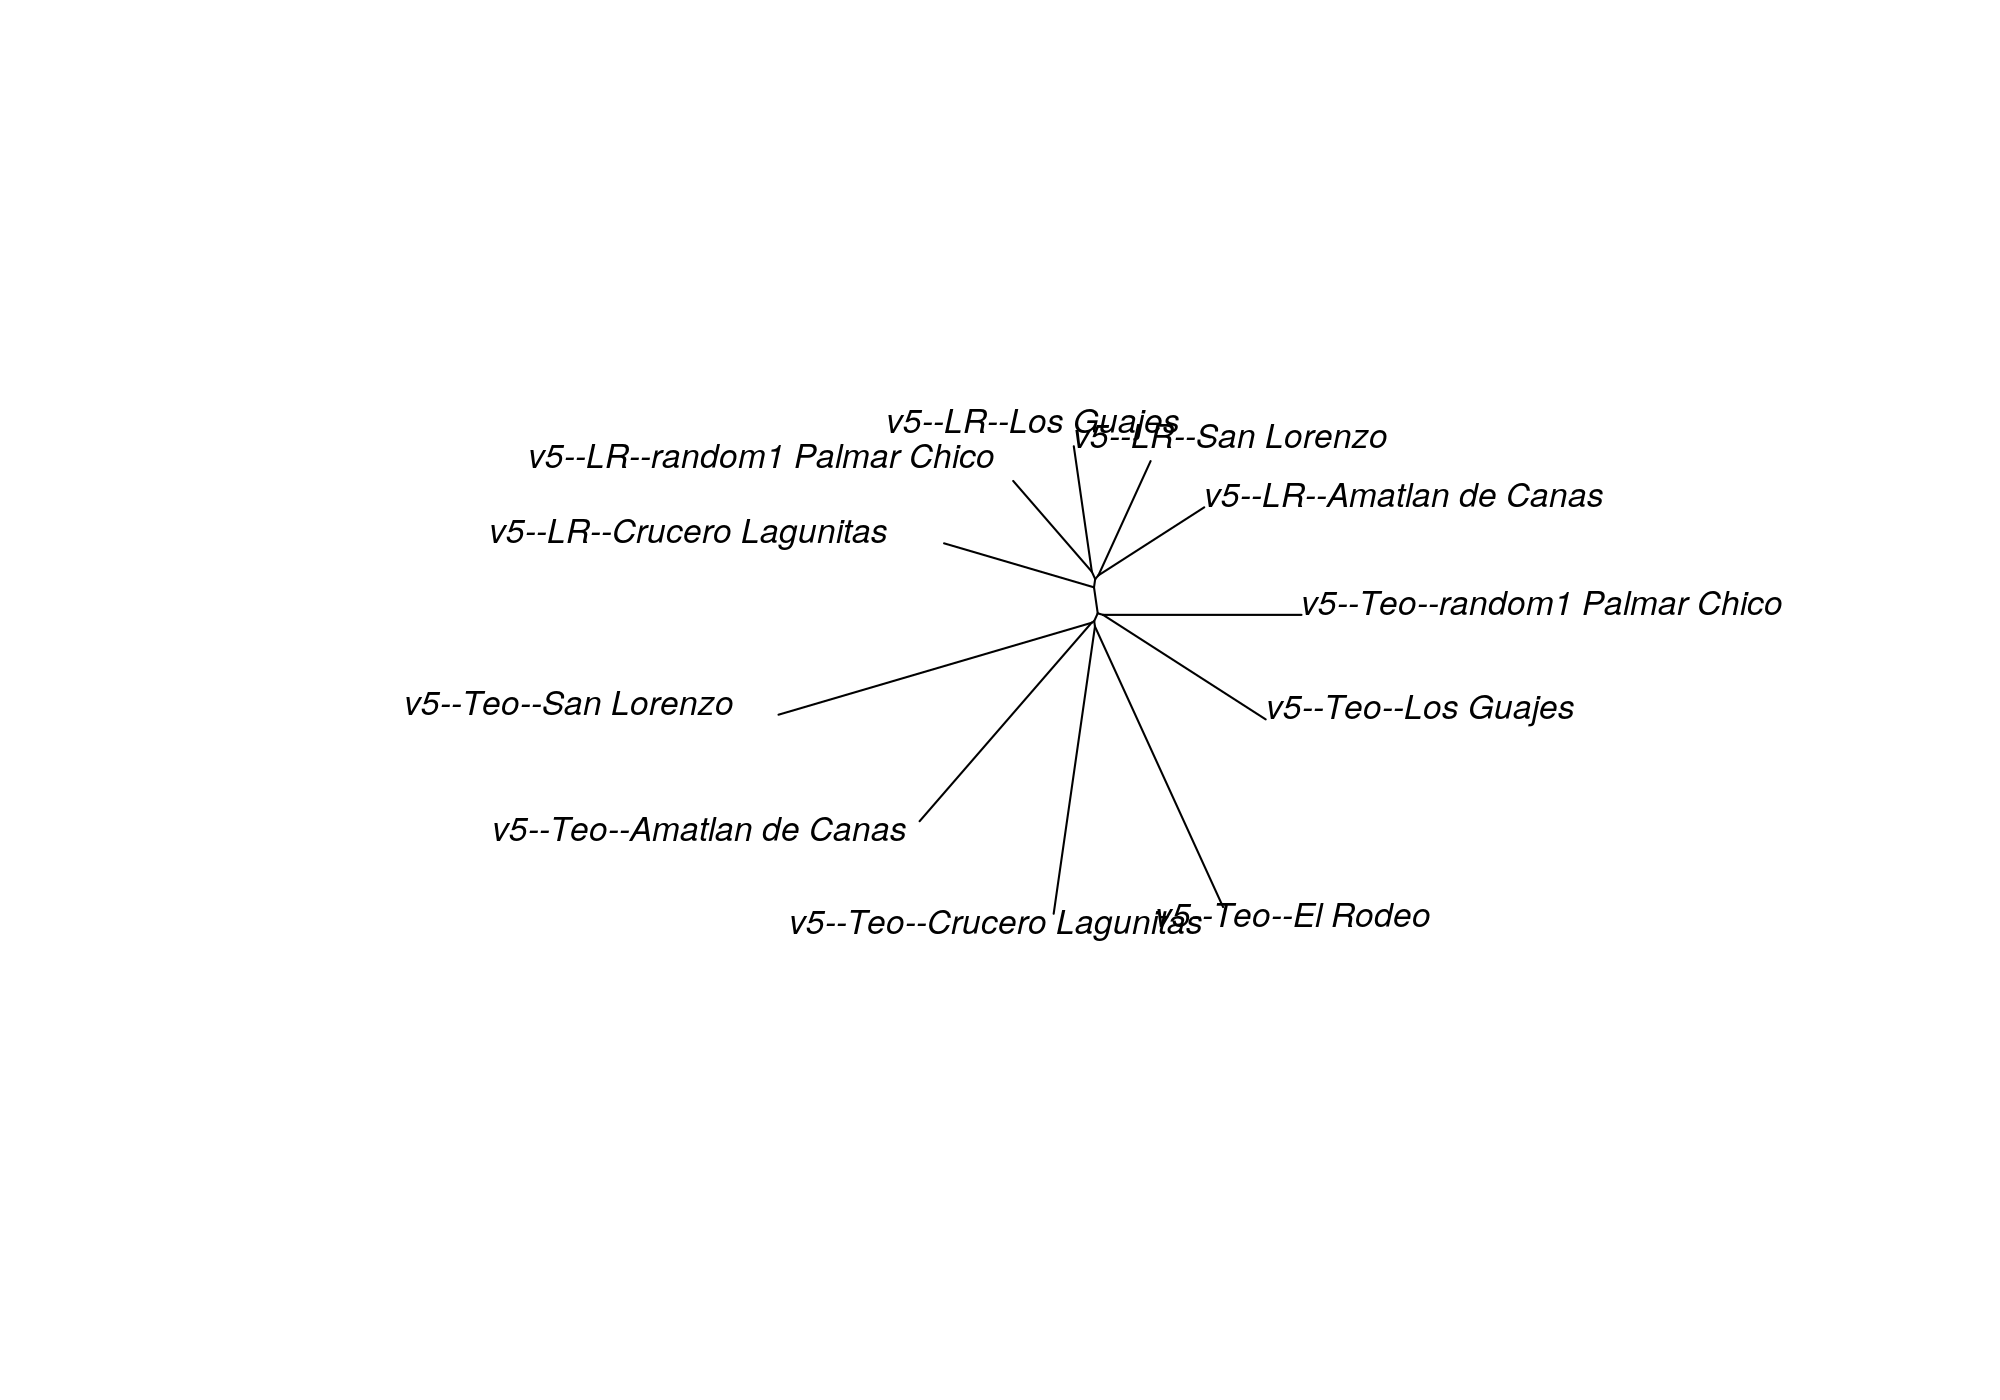

In [7]:
pop_types <- (names(neutral_freqs)[-c(1:3)] %>% str_remove_all('v5--') %>% str_split('--', simplify = TRUE))[,1]
pops <- (names(neutral_freqs)[-c(1:3)] %>% str_remove_all('v5--') %>% str_split('--', simplify = TRUE))[,2]
pop_pc <- neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t() %>% 
    prcomp()

plot(pop_pc$x[,1], pop_pc$x[,2], bg = factor(pops), pch = 21, cex = 2)
text(pop_pc$x[,1], pop_pc$x[,2], pops)


dist_mat <- neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t() %>% 
    dist()

plot.phylo(nj(dist_mat), type = "unrooted")

In [8]:
pos_vec <- select(sweep_freqs, end) %>% pull(end)

sweep_mat <- sweep_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t()

neut_mat <- 
    neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t()

rr <- get_rr(gen_map_all_chr, "chr1", sweep_freqs$end)

param_list <-
  parameter_barge(
    Ne =  50000,
    rec = rr,
    neutral_freqs = neut_mat,
    selected_freqs = sweep_mat,
    selected_pops = sel_vec,
    positions = pos_vec,
    n_sites = 20,
    sample_sizes = rep(10, nrow(neut_mat)),
    num_bins = 1000,
    sels = 10^seq(-5, -1, length.out = 15),
    times = c(1e2, 1e3, 1e4, 1e5),
    gs = 10^seq(-3, -1, length.out = 3),
    migs = 10^(seq(-3, -1, length.out = 2)),
    sources = sel_vec,
    locus_name = s_file,
    cholesky = TRUE
  )



In [9]:
rep(mean(apply(param_list$allFreqs, 1, mean)), 11)
quantile(apply(mvtnorm::rmvnorm(n = 10000, mean = rep(mean(apply(param_list$allFreqs, 1, mean)), 11), sigma = param_list$F_estimate), 2, sd), 0.01)

[1] 0.02158737 0.02158737 0.02158737 0.02158737 0.02158737 0.02158737
 [7] 0.02158737 0.02158737 0.02158737 0.02158737 0.02158737

Warning message in mvtnorm::rmvnorm(n = 10000, mean = rep(mean(apply(param_list$allFreqs, :
“sigma is numerically not positive semidefinite”


1% 
0.3387706

In [10]:
mode_wrapper <- function(barge, mode) {
       cle_out <- try(mode_cle(barge, mode))
       if(class(cle_out)[1] == 'try-error'){
           barge$cholesky  <- FALSE
           cle_out <- suppressWarnings(mode_cle(barge, mode))
           barge$cholesky  <- TRUE
       }
    return(cle_out)
}

t <- Sys.time()
#fit composite likelihood models
print("neutral")
neut_cle <- mode_wrapper(param_list, mode = "neutral")
print("ind")
ind_cle <- mode_wrapper(param_list, mode = "independent")
print("standing")
sv_cle <- mode_wrapper(param_list, mode = "standing")
print("mig")
mig_cle <- mode_wrapper(param_list, mode = "migration")

Sys.time() - t

[1] "neutral"
[1] "ind"
[1] "standing"
[1] "mig"


Time difference of 8.801101 mins

In [ ]:
head(neut_cle)

In [11]:
#neut <- unique(neut_cle$cle)

#merge data frame of all fit models
all_mods <-
  bind_rows(
    ind_cle,
    mig_cle,
    sv_cle
  ) %>%
    mutate(sel_pop_ids = paste(FREQ_POPS[sel_vec+3], collapse = "; "),
           neut_cle = unique(neut_cle$cle))
    
#max composite likelihood estimate 
#of all params over all models  
all_mods %>%
  group_by(model) %>%
  filter(cle == max(cle,na.rm=T)) %>%
  mutate(mcle = cle - neut_cle) %>%
  ungroup() %>%
  mutate(mcle_delta = mcle - max(mcle)) %>%
  arrange(desc(mcle)) 

best_mcle <- all_mods %>%
  group_by(model) %>%
  summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
  ungroup()  %>%
  arrange(desc(mcle))

(best_mod <- best_mcle %>% slice(1) %>% pull(model))
#best_mod <- "standing"


selected_sites,sels,cle,locus,gs,times,migs,sources,sel_pops,model,sel_pop_ids,neut_cle,mcle,mcle_delta
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
129699886,1.930698e-05,19594.61,../data/rdmc/sweep_freq/v5--sweep--chr5--0--226353449_start128809182_end129937508_pops1-2-3-4-5.txt,0.01,100,NA,NA,1-2-3-4-5,standing,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo,19591.22,3.392059,0.000000
129699886,1.930698e-05,19590.19,../data/rdmc/sweep_freq/v5--sweep--chr5--0--226353449_start128809182_end129937508_pops1-2-3-4-5.txt,NA,NA,0.1,2,1-2-3-4-5,migration,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo,19591.22,-1.032028,-4.424087
128809190,1.930698e-05,19499.39,../data/rdmc/sweep_freq/v5--sweep--chr5--0--226353449_start128809182_end129937508_pops1-2-3-4-5.txt,NA,NA,NA,NA,1-2-3-4-5,independent,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo,19591.22,-91.828444,-95.220504


`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.



[1] "standing"

In [ ]:
dim(neut_cle)

In [ ]:

all_mods %>%
  group_by(selected_sites, model) %>%
  filter(model == best_mod) %>%
  summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
  ggplot(aes(selected_sites, mcle, colour = model)) +
  geom_line() +
  geom_point() +
  xlab("Position") +
  ylab("Composite likelihood") +
  scale_color_brewer(palette = "Set1")


#visualize likelihood surface wrt selection coefficients
all_mods %>%
  group_by(sels, model) %>%
  filter(model == best_mod) %>%
  summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
  ggplot(aes(log10(sels), mcle, colour = model)) +
  geom_line() +
  geom_point() +
  ylab("Composite likelihood") +
  xlab("Selection coefficient") +
  scale_color_brewer(palette = "Set1") 

if (best_mod == "standing"){
    
    #visualize likelihood surface wrt age
    a  <- all_mods %>%
      group_by(times, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(log10(times), mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Age") +
      scale_color_brewer(palette = "Set1") 
    
    
    #visualize likelihood surface wrt age
    b <- all_mods %>%
      group_by(gs, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(gs, mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Initial allele frequency") +
      scale_color_brewer(palette = "Set1") 
    
    a / b

    
} else if(best_mod == "migration"){
     a  <- all_mods %>%
      group_by(migs, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(log10(migs), mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Migration rate") +
      scale_color_brewer(palette = "Set1") 
    
    b  <- all_mods %>%
      group_by(sources, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(factor(sources), mcle, colour = model)) +
      geom_point(size = 3) +
      ylab("Composite likelihood") +
      xlab("Source pop") +
      scale_color_brewer(palette = "Set1") 

    a+b
}


In [ ]:
sel_vec
paste(FREQ_POPS[sel_vec+3], collapse = "; ")